# Utility functions


In [4]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cpu'
import sys
import os
import iso8601
from datetime import datetime

import json
import string

In [5]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../data/bert_config.json')
bert_model = 'bert-base-uncased'

In [6]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

def formatTime(tz_time, datetime_object=False):
    isoTime = iso8601.parse_date(tz_time)
    ts = isoTime.timestamp()
    ts = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S:%f")

    if datetime_object:
        ts = datetime.fromisoformat(ts)
    return ts


In [ ]:
# c_text = "So one thing we can try is take the same domain names and join as a user to accept a PICC lines on the back end if you want to initialize a conference.Right so that we can spend one and I can say hey this is the last nominee nominee is a number of last in chance really to create because it is you are allocating a room in Trinity.So one thing we can try is take the same domain names and join as a user to accept a PICC lines on the back end if you want to initialize a conference.Right so that we can spend one and I can say hey this is the last nominee nominee is a number of last in chance really to create because it is you are allocating a room in Trinity."
# c_fv = getBERTFeatures(model1, "Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems.", attn_head_idx = -1)
# c_fv2 = getBERTFeatures(model1, "a circle call everything we can to is going to be is easy that so just turn it and we are going it short two", attn_head_idx = -1)
# #getSentMatchScore_wfeature(c_text, c_text, c_fv, c_fv2, nsp_dampening_factor = 0.7)
# 1-cosine(c_fv,c_fv2)

In [7]:
model1 = BertForPreTraining_custom(config)
model1.to(device)
#state_dict_1 = torch.load('../data/bert_10epc_inc_se+etherdata_1e-6_sl40_bt64.bin')
state_dict_1 = torch.load('../data/bert_10epc_se_1e-6_sl40.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

BertForPreTraining_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

## Topic extraction with keyphrase approach as cosine similarity.

In [ ]:
def getKPBasedSimilarity(text1,text2,model=None,tup1=None,tup2=None,layer = -1):

    """
    Calculates similarity between two sentences - based on noun phrases, verb<>noun phrases. Calculates pair-wise cosine similarity between candidate phrases
    returns mean of top-3 similar phrases as similarity

    Args:
    text1: required 
    text2: required
    model optional, required if tup1 and tup2 are provided
    tup1: bert features of `sent1` as returned by getBERTFeatures()
    tup2: bert features of `sent2` as returned by getBERTFeatures()
    layer: optional, BERT layer to extract features from

    Output:
    returns key-phrase based cosine similarity between the sentences
    """

    #text1 = customPreprocess(text1)
    #text2 = customPreprocess(text2)

    if (tup1 is not None) and (tup2 is not None):
        token_feats_1,final_feats1,text1_bert_tokenized = tup1
        token_feats_2,final_feats2,text2_bert_tokenized = tup2
    else:
        if model is not None:
            token_feats_1,final_feats1,text1_bert_tokenized = getBERTFeatures(model, text1, attn_head_idx=layer)
            token_feats_2,final_feats2,text2_bert_tokenized = getBERTFeatures(model, text2, attn_head_idx=layer)
        else:
            assert model is not None

    text1_sent_tokens = tokenize(text1)
    text2_sent_tokens = tokenize(text2)

    merged_feats_text1 = getWordFeatsFromBertTokenFeats(text1_sent_tokens,text1_bert_tokenized,token_feats_1)
    merged_feats_text2 = getWordFeatsFromBertTokenFeats(text2_sent_tokens,text2_bert_tokenized,token_feats_2)

    #get candidate key-phrases for both sentences
    kps_sent1,kps_loc_sent1 = getCandidatePhrases(text1)
    kps_sent2,kps_loc_sent2 = getCandidatePhrases(text2)
    
    sent1_kp_feats = getKeyPhraseFeatures(kps_sent1,kps_loc_sent1,merged_feats_text1,text1_sent_tokens)
    sent2_kp_feats = getKeyPhraseFeatures(kps_sent2,kps_loc_sent2,merged_feats_text2,text2_sent_tokens)

    sim_list = []
    for sent1_kp, feats1 in zip(kps_sent1,sent1_kp_feats):
        for sent2_kp, feats2 in zip(kps_sent2,sent2_kp_feats):
            if len(sent1_kp.split(' '))+len(sent2_kp.split(' '))==2:
                if len(sent1_kp.split(' ')[0])<4 or len(sent2_kp.split(' ')[0])<4:
                    continue
                curr_sim = 1-spatial.distance.cosine(feats1,feats2)
            else:
                if len(sent1_kp.split(' '))==1 or len(sent2_kp.split(' '))==1:
                    continue
                else:
                    curr_sim = 1-spatial.distance.cosine(feats1,feats2)
            sim_list.append(curr_sim)

    if len(sim_list)>3:
        sim_list = sim_list[0:3]
    if len(sim_list)>0:
        mean_dist = np.mean(sim_list)
    else:
        mean_dist = 0.0
        
    return mean_dist


In [ ]:
## utils for the above

import unicodedata
import itertools
from scipy import spatial
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from itertools import chain

def lambda_unpack(f):
    return lambda args: f(*args)

def tokenize(text, never_split = [], do_lower_case = True):
    """Tokenizes a piece of text."""
    text = _clean_text(text)
    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
        if do_lower_case and token not in never_split:
            token = token.lower()
            token = _run_strip_accents(token)
        split_tokens.extend(_run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)

    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

def _run_split_on_punc(text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
        char = chars[i]
        if _is_punctuation(char):
            output.append([char])
            start_new_word = True
        else:
            if start_new_word:
                output.append([])
            start_new_word = False
            output[-1].append(char)
        i += 1

    return ["".join(x) for x in output]

def _clean_text(text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
        cp = ord(char)
        if cp == 0 or cp == 0xfffd or _is_control(char):
            continue
        if _is_whitespace(char):
            output.append(" ")
        else:
            output.append(char)
    return "".join(output)

def _is_control(char):
    """Checks whether `chars` is a control character."""
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False

def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False

def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

def _run_strip_accents(text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
        cat = unicodedata.category(char)
        if cat == "Mn":
            continue
        output.append(char)
    return "".join(output)

def getWordFeatsFromBertTokenFeats(sent_tokens,bert_tokens,bert_token_feats):
    """
    #steps for merging the bert tokens to get the BERT features for actual words
    #1. iterate over the BERT base tokenizer
    #2. lookup for the actual word in the current BERT lookup postions
    #3. If found:
        #3a. the word is not tokenized further - use the current BERT features as word embedding
    #else:
        #3b. the word is tokenized in BERT - find the sequence of tokens and sum up the features to get the word vector
    """
    base_ctr = 0
    bert_ctr = 0
    word_feat_list = []

    for word in sent_tokens:
        if bert_tokens[bert_ctr] == word:#word not further tokenized, use the same feature vector
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr]))
            else:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr].detach().numpy()))
            base_ctr+=1
            bert_ctr+=1
        else:
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                aggr_feats = np.array(bert_token_feats[bert_ctr])
            else:
                aggr_feats = np.array(bert_token_feats[bert_ctr].detach().numpy())
            aggr_word = bert_tokens[bert_ctr]
            merge_next = True
            while merge_next and bert_ctr<len(bert_tokens)-1:
                if '#' in bert_tokens[bert_ctr+1]:
                    aggr_word = aggr_word+bert_tokens[bert_ctr+1]
                    bert_ctr+=1
                    if type(bert_token_feats[bert_ctr])==np.ndarray:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr])
                    else:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr].detach().numpy())
                else:
                    merge_next = False
                    bert_ctr+=1
            word_feat_list.append(aggr_feats)
    assert len(sent_tokens)==len(word_feat_list)
    return word_feat_list

def getCandidatePhrases(text, pos_search_pattern_list=[r"""base: {(<JJ.*>*<NN.*>+<IN>)?<JJ>*<NN.*>+}""",
                                           r"""nounverb:{<NN.*>+<VB.*>+}""",
                                           r"""verbnoun:{<VB.*>+<NN.*>+}"""]):
    
    #text = customPreprocess(text)
    punct = set(string.punctuation)
    all_chunks = []

    candidate_phrases = []
    for pattern in pos_search_pattern_list:
        curr_chunks=getregexChunks(text, pattern)
        candidate_phrases+=[' '.join(word for word, pos, 
                           chunk,ctr in group).lower() 
                  for key, group in itertools.groupby(curr_chunks, 
                  lambda_unpack(lambda word, pos, chunk, ctr: chunk != 'O')) if key]
    
    filtered_candidates = []
    for key_phrase in candidate_phrases:
        curr_filtr_phrase = stripStopWordsFromText(key_phrase,stop_words)
        if curr_filtr_phrase!=key_phrase and curr_filtr_phrase in candidate_phrases:
            curr_filtr_phrase = '' #can be considered duplicate
        if len(curr_filtr_phrase)>0:
            filtered_candidates.append(curr_filtr_phrase)
    candidate_phrases = filterCandidatePhrases(text,filtered_candidates)
    candidate_phrases,candidate_locs = getPhraseListLocations(text, candidate_phrases)

    return candidate_phrases,candidate_locs

def getregexChunks(text, grammar):

    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    return [(ele[0], ele[1], ele[2], ctr) for ele,ctr in zip(all_chunks,range(len(all_chunks)))]

def filterCandidatePhrases(text, candidate_phrases_list):
    """
    * Merges sub phrases into single phrase
    * Concatenate adjecent phrases
    * Retains duplicate phrases occurring at different positions
    """
    drop_list = []
    merge_list = []
    merge_list_start = []
    merge_list_end = []

    filtered_sent = removeStopwords(text)
    filtered_phrase_list = [removeStopwords(phrase) for phrase in candidate_phrases_list]

    start_pos_list, end_pos_list = getStartEndPOSList(text,candidate_phrases_list)
    filtered_start_pos_list, filtered_end_pos_list = getStartEndPOSList(filtered_sent,filtered_phrase_list)
    assert len(filtered_start_pos_list)==len(filtered_phrase_list)

    for i in range(len(start_pos_list)):
        curr_start,curr_end,ctr = start_pos_list[i],end_pos_list[i],i

        for j in range(i+1, len(start_pos_list)):
            lookup_start, lookup_end, lookup_ctr = start_pos_list[j], end_pos_list[j], j
            if curr_start==lookup_start and curr_end==lookup_end:
                continue
            if (curr_start<=lookup_start and curr_end>=lookup_end) or (lookup_start<=curr_start and lookup_end>=curr_end):
                if len(candidate_phrases_list[i])<len(candidate_phrases_list[j]):
                    drop_list.append(candidate_phrases_list[i])
                else:
                    drop_list.append(candidate_phrases_list[j])

        for k in range(len(start_pos_list)):
            if filtered_start_pos_list[i]-filtered_end_pos_list[k]==1:
                merge_list.append([candidate_phrases_list[i],candidate_phrases_list[k]])
                drop_list.append(candidate_phrases_list[i])
                drop_list.append(candidate_phrases_list[k])
                merge_list_start.append(min(start_pos_list[i],start_pos_list[k]))
                merge_list_end.append(max(end_pos_list[i],end_pos_list[k]))

    for ctr in range(len(merge_list)):
        candidate_phrases_list.append(text[merge_list_start[ctr]:merge_list_end[ctr]])
        
    doup_list = []   
    for kp1 in candidate_phrases_list:
        for kp2 in candidate_phrases_list:
            if kp1!=kp2 and kp2 in kp1:
                doup_list.append(kp2)
    #do not do set operation            
    for ele in drop_list:
        if ele in candidate_phrases_list:
            candidate_phrases_list.remove(ele)
            
    for ele in doup_list:
        if ele in candidate_phrases_list:
            candidate_phrases_list.remove(ele)

    return candidate_phrases_list

def removeStopwords(text):
    sent = ' '.join([tok for tok in text.split(' ') if tok not in stop_words])
    return sent


def getStartEndPOSList(text,candidate_phrases_list):
    start_pos_list = []
    end_pos_list = []
    processed_list = []
    for candidate in candidate_phrases_list:
        start_pos = [match.start() for match in re.finditer(candidate, text)]
        if len(start_pos)==1:
            processed_list.append(candidate)
            start_pos_list.append(start_pos[0])
            end_pos_list.append(start_pos[0]+len(candidate))
        else: 
            tok_ctr = processed_list.count(candidate)
            start_pos_list.append(start_pos[tok_ctr])
            end_pos_list.append(start_pos[tok_ctr]+len(candidate))
            processed_list.append(candidate)
    return start_pos_list, end_pos_list

def getPhraseListLocations(text, candidate_phrases):
    """
    locates the word indices of the key-phrase in the input text
    """
    phrase_idx_list = []
    token_sent_list = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]
    token_list = list(chain(*token_sent_list))
    
    for phrase in candidate_phrases:
        phrase_tokens = nltk.word_tokenize(phrase)
        phrase_idx = find_sub_list(phrase_tokens,token_list)
        phrase_idx_list.append(phrase_idx)
     
    processed_phrase_list = []
    processed_idx_list = []
    for phrase, loc_idx in zip(candidate_phrases,phrase_idx_list):
        if len(loc_idx)==0:
            processed_phrase_list.append(phrase)
            processed_idx_list.append(['-1']) #mismatch between nltk and bert tokenizers :-(

        if len(loc_idx)==1:
            processed_phrase_list.append(phrase)
            processed_idx_list.append(loc_idx[0])
        else:
            #count number of times the phrase has occurred in the list
            if phrase not in processed_phrase_list:
                kp_occ_ctr = candidate_phrases.count(phrase)
                if kp_occ_ctr == len(loc_idx):
                    #append current key-phrase `kp_occ_ctr` times into the lists
                    processed_phrase_list+=[phrase]*kp_occ_ctr
                    processed_idx_list+=loc_idx
                else: 
                    idx_drop_list = []
                    #the phrase index is calculated as part of another key-phrase index
                    #check other sublists that are 
                    #find other locations 
                    for lookup_loc in phrase_idx_list:
                        if lookup_loc!=loc_idx and len(lookup_loc[0])!=len(loc_idx[0]):
                            for i in range(len(loc_idx)):
                                if((set(loc_idx[i]) & set(lookup_loc[0]))== set(loc_idx[i])):
                                    idx_drop_list.append(loc_idx[i])
                    for to_insert_loc in loc_idx:
                        if to_insert_loc not in idx_drop_list:
                            processed_phrase_list.append(phrase)
                            processed_idx_list.append(to_insert_loc)
                            
    str_loc_list = []
    for ele in processed_idx_list:
        str_loc = ''
        for tok in ele:
            str_loc = str_loc+' '+str(tok)
        str_loc_list.append(str_loc.strip())
            
    return processed_phrase_list,str_loc_list

def getKeyPhraseFeatures(kp_list, kp_loc_idx,text_feats, text_tokens):
    
    key_phrase_feats = []
    for ele,loc_list in zip(kp_list,kp_loc_idx):
        if len(ele.split(' '))==1:
            if loc_list[0]== '-': #check getPhraseListLocations() for the reason
                idx_val = int(loc_list)
            else:
                idx_val = int(loc_list[0])
            key_phrase_feats.append(getTokenFeature(ele,idx_val,text_feats,text_tokens))
        else:
            curr_feature_vec = []
            for tok,tok_idx in zip(ele.split(' '),loc_list.split(' ')):
                curr_feature_vec.append(getTokenFeature(tok,int(tok_idx),text_feats,text_tokens))
            key_phrase_feats.append(sum(curr_feature_vec))
    return key_phrase_feats

def getTokenFeature(token, token_idx, text_feats, text_tokens):    
    if text_tokens[token_idx]==token:
        feat_vec = text_feats[token_idx]
    else:
        #print('Token not found in the location, searching entire text.: ', token)
        if token in text_tokens:
            idx_val = text_tokens.index(token)
            feat_vec = text_feats[idx_val]
        else:
            #print('Token not found.. returning default feature vector: ', token)
            feat_vec = np.full(len(text_feats[0]),0.01)
    return feat_vec

def getWordFeatsFromBertTokenFeats(sent_tokens,bert_tokens,bert_token_feats):
    """
    #steps for merging the bert tokens to get the BERT features for actual words
    #1. iterate over the BERT base tokenizer
    #2. lookup for the actual word in the current BERT lookup postions
    #3. If found:
        #3a. the word is not tokenized further - use the current BERT features as word embedding
    #else:
        #3b. the word is tokenized in BERT - find the sequence of tokens and sum up the features to get the word vector
    """
    base_ctr = 0
    bert_ctr = 0
    word_feat_list = []

    for word in sent_tokens:
        if bert_tokens[bert_ctr] == word:#word not further tokenized, use the same feature vector
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr]))
            else:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr].detach().numpy()))
            base_ctr+=1
            bert_ctr+=1
        else:
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                aggr_feats = np.array(bert_token_feats[bert_ctr])
            else:
                aggr_feats = np.array(bert_token_feats[bert_ctr].detach().numpy())
            aggr_word = bert_tokens[bert_ctr]
            merge_next = True
            while merge_next and bert_ctr<len(bert_tokens)-1:
                if '#' in bert_tokens[bert_ctr+1]:
                    aggr_word = aggr_word+bert_tokens[bert_ctr+1]
                    bert_ctr+=1
                    if type(bert_token_feats[bert_ctr])==np.ndarray:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr])
                    else:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr].detach().numpy())
                else:
                    merge_next = False
                    bert_ctr+=1
            word_feat_list.append(aggr_feats)
    assert len(sent_tokens)==len(word_feat_list)
    return word_feat_list

def stripStopWordsFromText(sent, stop_words):
    """
    Removes stop-words at the start and end of the inputs
    """
    fw_ctr = 0
    bw_ctr = 0
    for tok in sent.split(' '):
        if tok in stop_words:
            fw_ctr+=1
        else:
            break
    for tok in reversed(sent.split(' ')):
        if tok in stop_words:
            bw_ctr-=1
        else:
            break
    if bw_ctr!=0:
        stripped_kp = ' '.join(sent.split(' ')[fw_ctr:bw_ctr])
    else:
        stripped_kp = ' '.join(sent.split(' ')[fw_ctr:])
            
    return stripped_kp.strip()

def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))        
    range_list = [list(range(ele[0],ele[1]+1)) for ele in results]
    
    return range_list


In [ ]:
def getBERTFeatures_KP(model, text, attn_head_idx=-1):  # attn_head_idx - index o[]

    """
    Get BERT features for the `text`
    Args:
        model: BERT model of type `BertForPreTrainingCustom`
        text: required, get features for this text
        attn_head_idx: optional, defaults to last layer
    Returns:
        tuple - {token_feats[attn_head_idx][0],final_feats,tokenized_text}
    """

    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > 200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    #print('indexed_tokens: ', indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #print('tokens_tensor: ', tokens_tensor)
    _, _, token_feats, pool_out = model(tokens_tensor)
    final_feats = list(getPooledFeatures(token_feats[attn_head_idx]).T)
    return token_feats[attn_head_idx][0],final_feats,tokenized_text

# Parsing Meetings

## Timeline json meeting Input (NA)

In [ ]:
def parsemeeting(text):
    with open(text, 'r') as f:
        parsed_text = json.load(f)
    return parsed_text
text = parsemeeting('../data/timeline_result2.json')

In [ ]:
texts = ''
temp = ' '
for t in text['timeline']['transcriptSegments']:
    temp = ' ' +  t['text']
    texts = texts + temp
    

In [ ]:
## Get top 10 pims instead of all the segments.    
# texts = ''
# temp = ' '
# for t in text['segments']:
#     if t['transcriber'] == "google_speech_api":
#         temp = ' ' +  t['originalText']
#         print ("---text-----  \n\nspoken by: " + t['spokenBy'] + "\n")
#         print (temp, "\n\n\n")
#         texts = texts + temp
    

## Load meeting as csv and get only the top10 pims.

In [8]:
## load it as csv.
import pandas

df = pandas.read_csv('../data/ethercast_1.csv', index_col=False, header=0);
df = df.sort_values(by='created_at')

In [9]:
import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}
curl_test = {}
segment_contents = {}
texts = ''
curl_test["contextId"] ="6baa3490-69d6-48fc-b5d4-3994e3e8fae0"
curl_test["mindId"] = "01daayheky5f4e02qvrjptftxv"
curl_test["segments"] = []
for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
        print (segment, end=",")
        curl_test['segments'].append(json.loads(segment))
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

[nltk_data] Downloading package wordnet to /home/ray__/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{"id": "0399616ea53f4fa7ad42970ed8d78db4", "status": "completed", "deleted": false, "endTime": "2019-07-24T15:59:53Z", "duration": 13, "spokenBy": "8d6db5f7d9b74c54ba38fe710ffcaf3f", "createdAt": "2019-07-24T15:59:53.749758973Z", "deletedAt": null, "startTime": "2019-07-24T15:59:40Z", "updatedAt": "2019-07-24T15:59:55.678182079Z", "confidence": 0.5586346, "recordingId": "7a048eed4c964994a504c5842b141618", "transcriber": "deepgram", "languageCode": "en-US", "originalText": "Yes can't think still senior you sure that's coming.", "transcriptId": "68278dc5-403e-4500-9305-70b78a73faed"},{"id": "ae396e02e5084d9484969032d8b6067c", "status": "completed", "deleted": false, "endTime": "2019-07-24T16:00:02Z", "duration": 4, "spokenBy": "8d6db5f7d9b74c54ba38fe710ffcaf3f", "createdAt": "2019-07-24T16:00:02.265163994Z", "deletedAt": null, "startTime": "2019-07-24T15:59:58Z", "updatedAt": "2019-07-24T16:00:03.560268608Z", "confidence": 0.55431527, "recordingId": "fd23dfc5e9a045678913e773cb93552e", "t

In [ ]:
segment_contents

# get Communities from meetings.

In [10]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp


mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=False)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
    if len(sent.split(' '))<=6:
        continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    #fv[index] = getBERTFeatures_KP(model1, sent, attn_head_idx=-3)
    print (index)

258
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257


In [ ]:
# for index1, sent1 in enumerate(mod_texts):
#     for index2, sent2 in enumerate(mod_texts):
#         print ("Sentence 1:\n " + sent1 + "\nSentence 2:\n " + sent2 + "\n Cosine score:" + str(1-cosine(fv[index1],fv[index2])), end="\n\n\n")

In [11]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [ ]:
# v1 = getBERTFeatures(model1, mod_texts[0], attn_head_idx=-1)
# v2 = getBERTFeatures(model1, mod_texts[3], attn_head_idx=-1)
# getSentMatchScore_wfeature_cosine(mod_texts[0], mod_texts[3],v1,v2)

In [ ]:
# getKPBasedSimilarity(mod_texts[10], mod_texts[20], model1, fv[10], fv[20],layer= -3)

In [12]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2 and index2>index1:
            #score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
            score = getSentMatchScore_wfeature_cosine(sent1, sent2,fv[index1],fv[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257


## build graph using metric threshold. (NA)

In [ ]:
def build_community_graph(tg, mod_texts):
    com_graph = nx.Graph()
    for sent in list(tg.nodes()):
        com_graph.add_node(sent)
    for nodea in tg.nodes():
        for nodeb in tg.nodes():
            if nodea!=nodeb:
                if tg.edges[nodea,nodeb]['weight'] > 0.90:
                    com_graph.add_edge(nodea,nodeb)
    return com_graph
com_graph = build_community_graph(tg, mod_texts)

## build graph using statistical percentage

In [29]:
import math
import community
max_mod = 0
mod_v = 0
for v in [0.15, 0.10, 0.05]:
    flag = False
    for count in range(5):   
        temp_nodes = []
        for nodea,nodeb, weight in tg.edges.data():
            temp_nodes.append((nodea,nodeb,weight['weight']))
        temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

        temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*v)+1]

        com_graph = nx.Graph()
        for nodea,nodeb, weight in temp_nodes:
            com_graph.add_edge(nodea,nodeb)

        partition = community.best_partition(com_graph)

        mod = community.modularity(partition, com_graph)
        if mod > max_mod:
            max_mod=mod
            mod_v = v
        print ("The pruning value 'v' and modularity is: ", v, mod)
#         if mod > 0.3:
#             flag=True
#             print ("Modularity reached 3. The pruning value 'v' is: ", v)
#             break
        if mod==0:
            temp_nodes = []
            print ("Modularity reached 0. The pruning value 'v' is: ", 0.15)
            for nodea,nodeb, weight in tg.edges.data():
                temp_nodes.append((nodea,nodeb,weight['weight']))
            temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

            temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*0.15)+1]

            com_graph = nx.Graph()
            for nodea,nodeb, weight in temp_nodes:
                com_graph.add_edge(nodea,nodeb)

            partition = community.best_partition(com_graph)

            mod = community.modularity(partition, com_graph)
            flag=True
            break
    if flag:
        print()
        break

for count in range(5):
    temp_nodes = []
    for nodea,nodeb, weight in tg.edges.data():
        temp_nodes.append((nodea,nodeb,weight['weight']))
    temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

    temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*mod_v)+1]

    com_graph = nx.Graph()
    for nodea,nodeb, weight in temp_nodes:
        com_graph.add_edge(nodea,nodeb)

    partition = community.best_partition(com_graph)
    mod = community.modularity(partition, com_graph)
    if mod>=mod_v:
        break

The pruning value 'v' and modularity is:  0.15 0.21270301991748325
The pruning value 'v' and modularity is:  0.15 0.208609962799723
The pruning value 'v' and modularity is:  0.15 0.21215469213533208
The pruning value 'v' and modularity is:  0.15 0.21331755445970835
The pruning value 'v' and modularity is:  0.15 0.21006608711904226
The pruning value 'v' and modularity is:  0.1 0.24411167327683764
The pruning value 'v' and modularity is:  0.1 0.24474284864088477
The pruning value 'v' and modularity is:  0.1 0.24502196730212591
The pruning value 'v' and modularity is:  0.1 0.2443066291636374
The pruning value 'v' and modularity is:  0.1 0.24480165351676333
The pruning value 'v' and modularity is:  0.05 0.30373624640797947
The pruning value 'v' and modularity is:  0.05 0.30809862801072996
The pruning value 'v' and modularity is:  0.05 0.3040792346421023
The pruning value 'v' and modularity is:  0.05 0.298946946187544
The pruning value 'v' and modularity is:  0.05 0.30809862801072996


In [ ]:
# import networkx as nx
# nx.write_gexf(com_graph, "graph.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

/home/ray__/.pipenv/bert/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


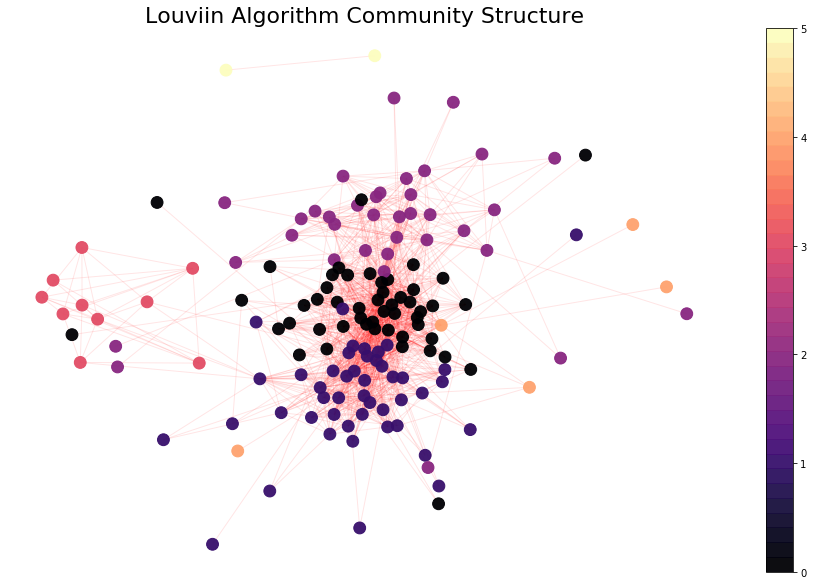

In [30]:
import community
import matplotlib.pyplot as plt
#partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [31]:
community.modularity(partition, com_graph)

0.3017876808363681

In [32]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [33]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
So that you increase a usability of the code all is three times like interfaces revenue this remote part which we do now use a lot of effect we do now use a lot of to but when started we to so that is not like the biggest thing but was definitely going to yes not having to do corpus collection management not having to to yeah, the Java selection speed staging path and still less to this day never had a problem with asuming it I we are all the changes.
It will also improve but basically essentially we can even use certificates and create roles in scope and does that value whether discussions should be lot to access et etc, but generally right now at this point, it is useful for process communication playlist somehow you want to have this time start to each with that worry a call pause get pads delete and what happens for us our PC was important call then using this because it is not a lot of data end client gives us we have a lot of transcript syst

In [18]:
com_graph.number_of_edges()

333

In [19]:
tg.number_of_edges()

33153

# Redefine the resulatant communities 

In [34]:
clusters = []
temp = []
prev_com = 0
for index,(word,cluster) in enumerate(partition):
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
        if index==len(partition)-1:
            clusters.append(temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [35]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [22]:
timerange

[[('Let is talk about the decision around that they we wanted to go with model this services or why we went to something in green. Yes, it good point to start because that master that the language that you choose hmmm from you know from I mean most of this is come from experiences both working at living to where we working on a model and moving to Groupon, which was a heavy presented company a with a huge model in between so some of the learning that we took from that was before getting into model the micro services. There is something that I be very was do not come a framework frameworks like Ruby or something that is too allows some invoices from kind of practices upon the developer and sort of expects the about the right code such that will only work well written in that order and to word away from the same words, you know specific in a workings and things will kind of make you words from the community around view also right. So especially when we work then like one of model and rai

In [36]:
timerange_detailed = []
temp = []
flag = False
pims = {}
index_pim = 0
index_segment = 0
for index,com in enumerate(timerange):
    temp = []
    flag = False
    #print ("-----community-----", index)
    for (index1,(sent1,time1,user1)), (index2,(sent2,time2,user2)) in zip(enumerate(com[0:]),enumerate(com[1:])):
        if sent1!=sent2:
            #print (time1, time2, (time2-time1).seconds)
            if ((time2-time1).seconds<=120):
                if not flag:
                    pims[index_pim] = {'segment'+str(index_segment):[sent1,time1,user1]}
                    index_segment+=1
                    temp.append((sent1,time1,user1))
                #else:
                    #print ('removing',time1, time2)
                    #temp.pop()
                pims[index_pim]['segment'+str(index_segment)] = [sent2,time2,user2]
                index_segment+=1
                temp.append((sent2,time2,user2))
                flag=True
            else:
                #print (time2, time1)
                if flag==True:
                    index_pim+=1
                    index_segment=0
                flag=False
    if flag==True:
        index_pim+=1
        index_segment=0
    #print ("-----timeRange-----\n", [j for i,j,k in temp])
    timerange_detailed.append(temp)            

## Redefing the resultant communities using different approach (NA)

In [ ]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user, [index]) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [ ]:
flattened_timerange = sorted([sent for com in timerange for sent in com], key= lambda kv: kv[1])

In [ ]:
flattened_timerange[29]

In [ ]:
# ft_re = []
# for (index1,sent1), (index2, sent2) in zip(enumerate(flattened_timerange),enumerate(flattened_timerange)):
#     if  sent1[1]==sent2[1]:
#         if len(ft_re)!=0 and ft_re[-1][1] == sent1[1]:
#             temp = []
#             temp.extend([[ft_re[-1][-1], sent1[-1], sent2[-1]]])
#             print (temp)
#             tot_com = list(set(temp))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             tot_com = list(set([sent1[-1], sent2[-1]]))
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#     else:
#         if ft_re!=[] and ft_re[-1][1] == sent1[1]:
#             tot_com = list(set([ft_re[-1][-1], sent1[-1]]))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             ft_re.append(sent1)
            
ft_re = []
tot_com = []
flag=False
for index1, sent1 in enumerate(flattened_timerange):
    if flag==True:
        if index1!=j:
            continue
        else:
            flag=False
    if flag==False:
        for index2, sent2 in enumerate(flattened_timerange):
            if index2>index1:
                if sent1[1]==sent2[1]:
                    if flag==False:
                        tot_com.extend([sent1[-1][-1],sent2[-1][-1]])
                        flag=True
                    else:
                        tot_com.extend([sent2[-1][-1]])
                        if index2==(len(flattened_timerange)-1):
                                tot_com = max(set(tot_com), key = tot_com.count) 
                                ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                else:
                    if flag==True:
                        tot_com = max(set(tot_com), key = tot_com.count)
                        ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                        j = index2
                    else:
                        ft_re.append(sent1)
                        flag = False
                    tot_com = []
                    break

In [ ]:
ft_re

# Alter communities based on time range and get Keyphrases

In [37]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + pims[index_pim][seg][0])
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [ph`rases for phrases, score in keyphrases]

SyntaxError: invalid syntax (<ipython-input-37-e9590e08f97a>, line 21)

In [ ]:

yet_to_combine = []
need_to_remove = []
for index1,i in enumerate(pims.keys()):
    for index2,j in enumerate(pims.keys()):
        if index1!=index2:
            if pims[i]['segment0'][1] >= pims[j]['segment0'][1] and pims[i]['segment0'][1] <= pims[j]['segment'+str(len(pims[j].values())-2)][1]:
                if (j,i) not in yet_to_combine and i not in need_to_remove and j not in need_to_remove:
                    yet_to_combine.append((i,j))
                    need_to_remove.append(i)

In [ ]:
for i,j in yet_to_combine:
    for k in pims[i]:
        if k!="keyphrase":
            if pims[i][k] not in pims[j].values():
                pims[j]['segment'+str(len(pims[j].values())-1)] = pims[i][k]
                #print (pims[i][k])
                continue
        else:
            extra_keyphrase = list(set(pims[i]['keyphrase'] + pims[j]['keyphrase']))
            pims[j]['keyphrase']=extra_keyphrase

In [ ]:
for i in need_to_remove:
    pims.pop(i)

In [ ]:
# meeting start time.
m_time = formatTime("2019-07-24T15:55:00Z", True)
for i in pims.keys():
    print ("\n\n\nPIMs ", i)
    print ("\n\nDiscussion:\n\n ")
    for seg in pims[i]:
        if seg!="keyphrase":
            print ("Minutes from the start of the meeting: ", pims[i][seg][1] - m_time , "\n")
            print (pims[i][seg][1], " ", pims[i][seg][0],"\n")
    print ("Keyphrases:\n\n ", pims[i]['keyphrase'])

## testing topic modelling with LDA (NA)

In [ ]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in new_text]
#doc_clean = [clean(new_text[1]).split()]

In [ ]:
doc_clean

In [ ]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [ ]:
print(ldamodel.print_topics())

## Testing keyphrase for the timerange (NA)

In [ ]:
pims = {
	"0": {
		"segment0": ["Like my per month to date most likely as we excuse into which we can that be better more consistent but General aw strategy what they say is have one Lambda the internet coming HTML segment notify is attached a general hook for the data uploaded the Lambda function who associate to the S3 bucket and have that pan out all other language like be a dispatcher. Yeah, thats.", "2019-06-28T06:16:58Z", "2982d23c-1e59-476d-88c8-a42376324142", "ebe8604a02c84952bb7ea9dfccd6c1df"]
	},
	"1": {
		"segment0": ["From by will sync up offline first trusting watertight preview will move manually create a bucket in staging environment and try to use it for testing but what I am expecting is not be a big change. What we what we can do is we can we can remove that CD and table itself from the database because the student table and other other things are actually only used for you know, this sets these things so we give you can remove them. So we will now will have a less overhead even in the future. So because after this change we are we are never going to use the stimuli. and.", "2019-06-28T06:11:11Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "0ef8d453e7bb41d3bd11153827df076a"]
	},
	"2": {
		"segment0": [
			["All right create an issue. Well track it should be a small thing even in the back end to handle. Yeah, I will see if I can look into it today."], "2019-06-28T05:35:58Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "f2d6bb774d5f4649b2e4f15bf07052ad"
		],
		"segment1": [
			["Nothing was done. Headmistress, I would wear black in the public Channel. We need to prompt Channel Minds. Also, I will check with Rashon thundergun. It was another."], "2019-06-28T05:39:19Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "418c719a0f5e4888b242df011e818aa3"
		],
		"segment2": [
			["And updated methods for that which I take do too. Okay. Yeah, I will look into that."], "2019-06-28T05:39:35Z", "d65899ed-e47e-4611-8c2c-59b154ff6a3f", "136b9ea1ccaf461facc5e7953a520ff6"
		]
	},
	"3": {
		"segment0": [
			["Its similar than better to go with S3. If GitHub is not giving you just artifact reading scope or something which release artifact reading Scopes even then it can be weird because if we keep tagging or create a good stuff that are not Jesus files are also generated. We need to prevent them from able to downloading do not also even if they do not we have to protect the code right should not be vulnerability this this take that what is the effort to from Reading from your front door if Jacob does give you anything fixed capacity?. ."], "2019-06-28T05:46:56Z", "2982d23c-1e59-476d-88c8-a42376324142", "8c4e8716db754f82b1ed36c449fa15a3"
		],
		"segment1": [
			["Another markers with calibration issue. I will also take a look on the back end. I know that we have to trim the edges to remove the flashin but I do think that if someone puts a empty space between two sentences that can cause an issue. I will just go check. Why is that occurring and see if it is something easy to pick up and then the back end also?."], "2019-06-28T05:50:04Z", "2982d23c-1e59-476d-88c8-a42376324142", "3c74a71652394d65abed891a412c008d"
		]
	},
	"4": {
		"segment0": [
			["You things on whether can we go eat on to Lambda or whether she should whether it should be based on the current key phrase. Maybe we will just take it off way, or I will talk to Sasha Hank and understand and get those details. We did have some plans to move it along."], "2019-06-28T05:57:22Z", "92b4588f-74cc-42f0-bf6d-eec0b6198ade", "6b474e34b42a4514b7689a378bc47c66"
		],
		"segment1": [
			["Between making calls on Tims and waiting on the one that comes last. Yeah that still happen because we will have to wait on the consensus of the what we need to do again is somewhat more on the cause they custom server is not doing anything and then it out into my you are still paying for the execution of the Pim. Lambda looks right at is one thing you can reduce but also the fact that we are right now waiting on Transit segment to complete I think within being the change we will need to wait on transcript second segment to be analyzed. Those are the events that trigger are some regeneration. So if it makes it and because that tramp is segment competed in already in the event of are acting on making this switch to the next most relevant is not a big problem. So it is more even driven so we do not need to wait on okay. Okay. Yeah, and then on the."], "2019-06-28T06:00:48Z", "2982d23c-1e59-476d-88c8-a42376324142", "f5c2855a681c40c8b5a77a85c5c0fd6d"
		],
		"segment2": [
			["Loved it. Thats fine. For now. I think you do. I think once you go to production, we need to figure out a way eventually to not lock sensitive information like transcript segment data Etc. And that will cause some you know issues still doing that. So but ceasing to your fine, too. Yeah."], "2019-06-28T06:02:50Z", "2982d23c-1e59-476d-88c8-a42376324142", "f56de51245ce4fa69c6628e5dc066369"
		],
		"segment3": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		],
		"segment4": [
			["I think when cat had reduced it to Fighters, I think Sicilian fighter he moved to by Torchlight and side by and all the mines and this one. So overall I think the thing got to do but we ended up using layers so we might be can end up adding both the layers for five dots by touch light and maybe scifi known by all the psychic number like it has layers and learning anything network accessible routes like that, but if sound 50mb."], "2019-06-28T06:06:36Z", "2982d23c-1e59-476d-88c8-a42376324142", "cc29605c0446480f8ace87c4d6593d8a"
		],
		"segment5": [
			["So currently was just working on the refactoring of bug book printing that is done basically it is in like the record reviews review comments have to just address it so apart from the doe those comments look straight forward or should not be a bigger big thing is basically so the other part is the pims part the the pins which are not seen in the mix does not constitute the last last few segments the meeting right? So that issue if started working on it like probably a bit Monday should be able to send the send it for review that code. Okay. Yeah that I maybe I will have to ask like more technical things. I will have to ask like if there is anything which I am missing missing I will call you again."], "2019-06-28T06:08:07Z", "6e8408ce-1072-4209-9e82-945701c7b86c", "439f3d6209184e19a7de54c59a8c4533"
		],
		"segment6": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		]
	},
	"5": {
		"segment0": ["But we we have done it. We have done it only from our office and I am not confused coming from that one will because people in the calls are like variables XnumberX  scholar two persons called Waterloo. We visited a real scenario kind of thing according a minimum XnumberX people per call because we just need to load test it and because it is normal generous mood worth but under the cave under the load, how does how its behaving that we need to check? Yeah.", "2019-06-28T06:21:56Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "b573665bbeae49bdb26020751122dfc1"]
	}
}

In [ ]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + ''.join([i for i in pims[index_pim][seg][0]]))
            print (keyphrase_text)
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [ ]:
pims

## keyphrases comparision with word2vec (NA)

In [ ]:
with open("../data/meetings_slack_embeddings.pkl","rb") as f:
    emb = pickle.load(f)

In [ ]:
nodea = 'sql'
nodea_fv = emb[nodea]
closest_match =[]
for nodeb in emb.keys():
    if nodeb!=nodea:
        diff = 1 - cosine(emb[nodeb], nodea_fv)
        closest_match.append((nodeb, diff))
closest_match_sorted = sorted(closest_match, key= lambda kv:kv[1], reverse=True)

In [ ]:
closest_match_sorted[:5]

In [ ]:
import pandas

df = pandas.read_csv('../data/query_resultsync2.csv', index_col=False, header=0);

import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}

segment_contents = {}
texts = ''

for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
    #if "google" not in data['transcriber']:
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

In [ ]:
texts

In [ ]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

gr = GraphRank()
tp = TextPreprocess()
utils = GraphUtils()

original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

#keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
#pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [ ]:
com_graph = GraphRank()
nodes_list = []
for indexa, nodea in enumerate(list(word_graph.nodes())):
    for indexb, nodeb in enumerate(list(word_graph.nodes())):
        if indexb>indexa:
            if nodea not in emb.keys() or nodeb not in emb.keys():
                #nodes_list.append((nodea,nodeb,0.5))            
                continue
            nodes_list.append((nodea,nodeb,cosine(emb[nodea],emb[nodeb])))
#print (*nodes_list, sep="\n")
nodes_list_sorted = sorted(nodes_list, key=lambda kv: kv[2], reverse=True)

nodes_list = nodes_list_sorted[:math.ceil(len(nodes_list_sorted)*0.05)+1]

com2_graph = nx.Graph()
for nodea,nodeb, weight in nodes_list:
    com2_graph.add_edge(nodea,nodeb)

partition = community.best_partition(com2_graph)

In [ ]:
community.modularity(partition, com2_graph)

In [ ]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [ ]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (word)
        current=cluster
    else:
        print (word)

## testing ground

In [ ]:
text_1 = "We have now created a simple network with Terraform on GCP. You can do a lot more with terraform such as setting up compute instances, firewall rules and much more. I thought this was necessary for the kinds of apps I was working on. And with that in mind, I tried many approaches and frameworks for implementing the same pattern: Single-page applications (SPA). The next thing we shall do is get the necessary credentials from GCP. Go to the GCP console menu and select APIs & Services then Credentials. Now click the Create Credentials button and choose Service Account Key. On the next screen choose Compute Engine default service account and JSON then click Create. This will download a json file to your computer, move this file to the folder where we shall write our terraform code. This file contains sensitive information so do not store it in a public repository or make it public."
text_1 = [sent for sent in text_1.split('. ')]
text_2 = "properly applied HR strategies ensure that  strategic recruiting and retention processes are created that fit the organization.There's a clear need for increased visibility to drastically improve sales. But in order to get more visibility, businesses have to spend more money. When that well runs dry, what are you supposed to do?.  strategically applying smart HR insights into different areas of the business tends to improve employee engagement throughout the company. However, identifying the right strategies to market your business is often likened to rocket science.  Some businesses have been built solely on the backs of social media. How do you get your message to the right audience and do it effectively? How do you boost visibility and increase sales while sustaining a profit with a converting offer? Today, with so much vying for our attention from social media, to search engine optimization, blogging and pay-per-click advertising, it's easy to see why most are ready to pull their hair out.The truth is that what got you to this point in business is likely not going to get you to the next level. If you're feeling stuck, join the fray. Most entrepreneurs are so busy working 'in' their businesses that they fail to work 'on' their businesses. As a result of dealing with the day-to-day operations of a company that includes customer hand-holding, supply-chain demands and more, we often neglect to wield the right marketing strategies that will help fuel our business's growth."
text_2 = [sent for sent in text_2.split('. ')]
print(len(text_1),len(text_2))

In [ ]:
c_fv = getBERTFeatures(model1,"", attn_head_idx = -1)
c_fv2 = getBERTFeatures(model1, "", attn_head_idx = -1)
#getSentMatchScore_wfeature(c_text, c_text, c_fv, c_fv2, nsp_dampening_factor = 0.7)
1-cosine(c_fv,c_fv2)

In [ ]:
label = {}
for x in range(10):
    label[x]="in-domain" 
for x in range(10,20):
    label[x]="out-of-domain" 


In [ ]:
label

In [ ]:
for index1, text1 in enumerate(text_1+(text_2)):
    for index2, text2 in enumerate(text_1+(text_2)):
        if index2>index1:
            text1_fv = getBERTFeatures(model1,text1, attn_head_idx = -1)
            text2_fv = getBERTFeatures(model1,text2, attn_head_idx = -1)
            cosine_similarity = 1 - cosine(text1_fv, text2_fv)
            metric_similarity = getSentMatchScore_wfeature(text1, text2, text1_fv, text2_fv, nsp_dampening_factor = 0.7)
            
            print (label[index1] + "  and   " + label[index2] + "   scores: " )
            print ("cosine similarity: " + str(cosine_similarity))
            print ("metric similarity: " + str(metric_similarity))
            print ("\n\n")

In [ ]:
## subtopics

topic_1 = "We have now created a simple network with Terraform on GCP. You can do a lot more with terraform such as setting up compute instances, firewall rules and much more. The next thing we shall do is get the necessary credentials from GCP. Go to the GCP console menu and select APIs & Services then Credentials. Now click the Create Credentials button and choose Service Account Key. On the next screen choose Compute Engine default service account and JSON then click Create. This will download a json file to your computer, move this file to the folder where we shall write our terraform code. This file contains sensitive information so do not store it in a public repository or make it public."
topic_1 = [sent for sent in topic_1.split('. ') if sent!=""]
topic_2 = "I thought this was necessary for the kinds of apps I was working on. And with that in mind, I tried many approaches and frameworks for implementing the same pattern: Single-page applications. If you work in the JavaScript ecosystem, you are most likely aware of how difficult it is to manage dependencies.When one of your core libraries releases a major version, it is time to start thinking about upgrading. Imagine that a library named X has a peer dependency on React and you are migrating your application to React. Maintaining an application with a large codebase requires a lot of discipline and having your dependencies up to date should be a top priority for your team and organization. "
topic_2 = [sent for sent in topic_2.split('. ') if sent!=""]
print(len(topic_1),len(topic_2))

In [ ]:
label2 = {}
for x in range(8):
    label2[x]="topic_1" 
for x in range(8,14):
    label2[x]="topic_2" 


In [ ]:
for index1, text1 in enumerate(topic_1+(topic_2)):
    for index2, text2 in enumerate(topic_1+(topic_2)):
        if index2>index1:
            text1_fv = getBERTFeatures(model1,text1, attn_head_idx = -1)
            text2_fv = getBERTFeatures(model1,text2, attn_head_idx = -1)
            cosine_similarity = 1 - cosine(text1_fv, text2_fv)
            metric_similarity = getSentMatchScore_wfeature(text1, text2, text1_fv, text2_fv, nsp_dampening_factor = 0.7)
            
            print (label2[index1] + "  and   " + label2[index2] + "   scores: " )
            print ("cosine similarity: " + str(cosine_similarity))
            print ("metric similarity: " + str(metric_similarity))
            print ("\n\n")

# similarity comparison

In [ ]:
sa = []
for edgea, edgeb, weight in tg.edges.data():
    #print ("Text A: ")
    #print (mod_texts[edgea])
    #print ("\n\nText b: ")
    #print (mod_texts[edgeb])
    #print ("\n\nsimilarity score:", weight['weight'])
    #print ("\n\n\n")
    sa.append((edgea, edgeb, weight['weight']))

In [ ]:
sa_sorted = sorted(sa, key=lambda kv: kv[2], reverse=True)

In [ ]:
for edgea, edgeb, weight in sa_sorted:
    print ("Text A: ")
    print (mod_texts[edgea], edgea)
    print ("\n\nText b: ")
    print (mod_texts[edgeb], edgeb)
    print ("\n\nsimilarity score:", weight)
    print ("\n\n\n")

In [ ]:
tg.get_edge_data(36,94)

In [ ]:
for edgea, edgeb, weight in tg.edges.data():
    print ("Text A: ")
    print (mod_texts[edgea])
    print ("\n\nText b: ")
    print (mod_texts[edgeb])
    print ("\n\nsimilarity score:", weight['weight'])
    print ("\n\n\n")